# Imports

In [1]:
import sys
import matplotlib.pyplot as plt
import warnings
import torch

warnings.filterwarnings("ignore")
sys.path.append('../../')
sys.path.append("/home/xinqiao/m3_learning/m3_learning/src")

In [2]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2 

In [3]:
from m3_learning.viz.printing import printer
from m3_learning.viz.style import set_style
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.Bright_Field_NN.Dataset import Bright_Field_Dataset
from m3_learning.nn.Bright_Field_NN.Viz import Viz
from m3_learning.nn.Bright_Field_NN.Autoencoder import ConvAutoencoder
from m3_learning.viz.layout import layout_fig, labelfigs

# Specify the filename and the path to save the file
save_path = './../../../Data/2023_Bright_Field'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png'])

# Set the style of the plots
set_style("printing")

2023-07-07 12:45:13.808954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 12:45:13.955410: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-07 12:45:14.492441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xinqiao/anaconda3/envs/m3/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-07 12:45:14.492512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

printing set for seaborn


In [20]:
# defines Dataset object using images from specified folder
dset = Bright_Field_Dataset(f'{save_path}/Annealed','Annealed_results','Annealed',verbose=False)

# list  paths to image data
# dset.list_imgs()

## Preprocessing

1. Images were cropped, and Gaussian background subtraction was applied. This result is written to the dataset named 'All_filtered' in the h5 file. 
2. The Pycroscopy package  was  used  to  sample  (128,128)  sized  sliding  windows  and  apply  a  Hanning  window and Fast Fourier Transform (FFT). Applying  FFT  to  windowed  images  provides  localized information  about  periodicity  and  reduces  bias  caused  by  sample  warping. In standard TEM, the FFT is used to calculate things such as lattice (d) spacing and planar orientation.
3. The logarithm is applied, along with a threshold and standard scaling.
4. The preprocessed data is a stack of (128,128) windows of length $T•n•n$, where $T$ is the number of temperatures sampled and $n$ is the number of windows sampled along  each  side  of  the  image.

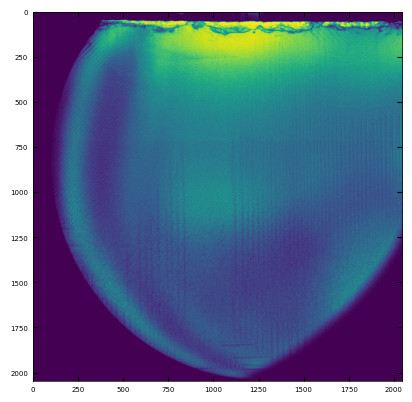

In [36]:
# extract array of image at rampdown, 50 deg celsius
im = dset.get_raw_img('Ramp_Down',"50")
plt.imshow(im)
plt.show()

In [6]:
# # Write image data to h5 file
# # saves original images as well as 
# # cropped images with gaussian filter applied
dset.write_h5(200,300,1400)

100%|██████████| 43/43 [00:18<00:00,  2.32it/s]


In [37]:
# Customize window parameters
# This will run very slow for small step sizes
window_parameters = {'fft_mode': 'abs',
                    'mode': 'fft',
                    'window_size_x': 140,
                    'window_size_y': 140,
                    'window_step_x': 70,
                    'window_step_y': 70,
                    'zoom_factor': 2}

# Write windows
wins = dset.write_windows(window_parms=window_parameters,overwrite=True)

100%|██████████| 43/43 [08:27<00:00, 11.81s/it]


## Visualization

In [30]:
# create vizualizer object
viz = Viz(dset,printer=printing)

# add scalebar
viz.scalebar_ = {"width": 273.4, "scale length": 50, "units": "nm"}


./../../../Figures/2023_Bright_Field/Ramp_Up_23_raw.png


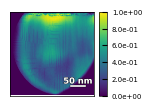

In [31]:
# view raw image
img_name = ['Ramp_Up','23']
viz.view_raw(img_name)

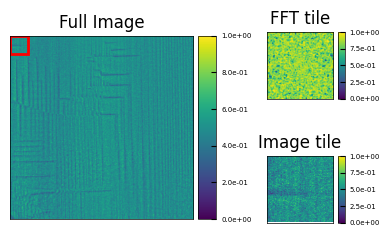

In [39]:
# view windows
viz.view_window(img_name,0,0)

# Training

Next,  the  FFT dataset   runs   through   a   model   inspired   by   the   joint   rotationally-invariant variational autoencoder, where input is compressed into a latent space with an additional discrete rotation representation, then reconstructed to  compare to  the original image. The model used in this  article  disentangles  the  input  datasets  scaling,  rotational,  and  translational  elements  and appends them to the latent representation. 

The encoder receives a batch of (128,128) images, which are downsampled and flattened to a feature vector with 8 points, as shown in Figure 2b. 

The  feature  vector  is  then  used  to  construct  three  affine  matrices,  with  the  first  two  points corresponding to the x and y scaling, the third point to the rotation angle, and the fourth and fifth points to the x and y translation. The eight features and selected affine transformations are shown in SI video.

The scaling, rotation, and translation matrices were then used to generate three respective affine grids with shape (2,2,2), and the final latent representation concatenates the feature vector and affine grids. 

Finally, the feature vector and spatial transformer grids are flattened  and  used  to  reconstruct  the  original  input.  

The  model  parameters  are  tuned  during training using the loss function shown in Figure2e. The Mean-Squared-Error(MSE) between the input and reconstructed images tests the latent representation for completeness, while L1 Regularization encourages sparsity and prevents overfitting.

Tips:
* `embedding_size` should be $2n^2$. This corresponds to an affine grid is of shape $(b,1,n,n)$ in the latent space. (ex. `embedding_size` can be $2*2*2 = 8$ or $2*3*3 = 18$)
* Don't make $n$ too big. The final output will be of shape $(b,4,2*n*n)$ because we stack the affine grids for decoding
* If nothing saved, it is because your model is not improving. It only saves if the loss is less than the last best loss

In [40]:
# defined model parameters
encoder_step_size = [dset.get_shape('windows/windows_logdata')[-2],
                     dset.get_shape('windows/windows_logdata')[-1]]
pooling_list = [4,4,2]
decoder_step_size = [8,8]
upsampling_list = [2,2,4]
embedding_size = 8
conv_size = 128
batch_size = 32

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

# define model
model = ConvAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)

In [ ]:
# Load pretrained model weights if you have them
model.load_weights(
        '/home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/Domain_Weights/(2022-05-18, 10 08)_epoch 00043_trainloss 0.2921_coef 5.0000E-08.pkl'
)

In [47]:
# train model
h = dset.open_combined_h5()
model.Train(
    data = h['windows']['windows_logdata'][:],
    coef_1=1e-5,
    epochs=2,
    with_scheduler=False,
    folder_path="Domain_Weights",
    batch_size=batch_size,
    save_all=True
)

h.close()

100%|██████████| 486/486 [02:34<00:00,  3.15it/s]


Epoch: 000/001 | Train Loss: 2.0972e-02
.............................


100%|██████████| 486/486 [02:35<00:00,  3.13it/s]


Epoch: 001/001 | Train Loss: 1.1971e-02
.............................


## Analyze embeddings

* put full path when you load. It's the easiest way

In [42]:
# Load model weights
model.load_weights(
        '/home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/Domain_Weights/(2022-05-18, 10 08)_epoch 00043_trainloss 0.2921_coef 5.0000E-08.pkl'
)

In [43]:
h = dset.open_combined_h5()
embedding, rotation, translation, scaling = \
    model.get_embedding(h['windows']['windows_logdata'][:])
h.close()

100%|██████████| 486/486 [01:22<00:00,  5.87it/s]


In [46]:
# Layout images of filtered image, embeddings, and transforms at all temperatures
viz.layout_embedding_affine(embedding,rotation,translation,scaling)

  0%|          | 0/43 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/xinqiao/anaconda3/envs/m3/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 478, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
  5%|▍         | 2/43 [06:41<2:17:02, 200.56s/it]


KeyboardInterrupt: 

In [16]:
# Builds a Movie
folder = f"./embedding_affine_maps"
output_folder = "./embedding_movies/"

# function to make the movie
make_movie("embeddings_through_temperatures", folder, output_folder, "png", 3, reverse=False)

## Analyze embeddings

In [14]:
from skimage import data
from skimage.transform import resize
import numpy as np

# im = data
# test_emb = 

In [15]:
h = dset.open_combined_h5()
h['windows']['windows_logdata']

<HDF5 dataset "windows_logdata": shape (1548, 128, 128), type "<f4">

In [59]:
test = resize(data.cat()[:,:,0],(6,6))

In [60]:
test.shape

(6, 6)

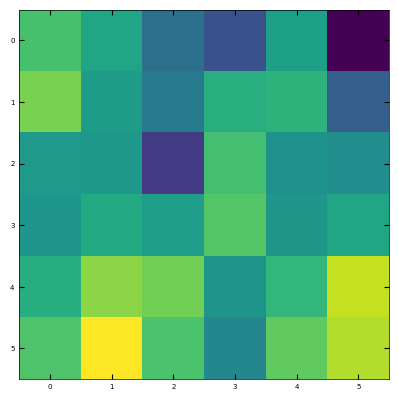

In [61]:
plt.close('all')
plt.imshow(test)
plt.show()

In [62]:
dat = np.resize(test.flatten(),1548)
dat_ = np.array([dat for i in range(8)]).T

<Figure size 640x480 with 0 Axes>

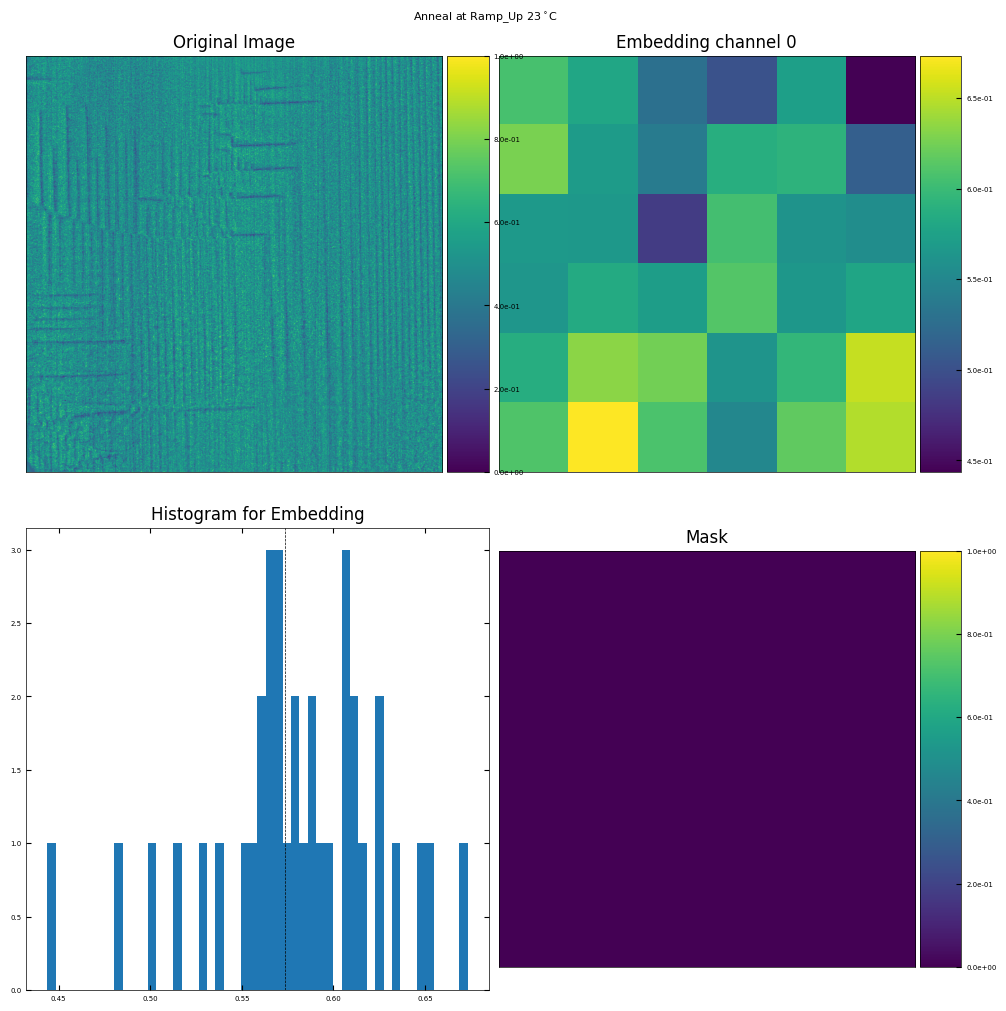

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [72]:
viz.make_mask(dat_,0,0,save_folder='./masking',eps=1)